# Data processing

In [9]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from nltk import word_tokenize

In [10]:
df = pd.read_csv('final.csv')

In [11]:
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'joint_tweets','fullname','id','lists'])
df = df.drop(df.index[[336]])

In [12]:
###remove data that has null values
data = df[df['twitter'].notnull()]

In [13]:
data_train = data[data['followers'].notnull()]
data_train = data_train[data_train['market_value'].notna()]

data_train.index = range(len(data_train))


In [14]:
###process height feature
data_train['height_ver2'] = data_train['height'].apply(lambda x: str(x).replace(',', '').replace('m', ''))


In [15]:
###contract start date 
data_train['join_date_ver1'] = data_train['join_date'].apply(lambda x: x if '20' in x else 0)

data_train['join_date_ver2'] = data_train['join_date_ver1'].apply(lambda x: (datetime.datetime.strptime("Dec31,2019", "%b%d,%Y").date() - datetime.datetime.strptime(x, "%b%d,%Y").date()).days/365 if x!=0  else 0)

In [16]:
###contract end date
data_train['exp_date_ver1'] = data_train['exp_date'].apply(lambda x: x if '20' in x else 0)

In [17]:
def date_change(x):
    try:
        ndays = (datetime.datetime.strptime(x, "%d.%m.%Y").date() - datetime.datetime.strptime("Dec31,2019", "%b%d,%Y").date()).days
    except:
        ndays = 0
    return ndays/365
        

In [18]:
data_train['exp_date_ver2'] = data_train['exp_date_ver1'].apply(date_change)

In [19]:
###data joined twitter feature
data_train['date_joined_twitter_ver1'] = data_train['date_joined'].apply(lambda x: str(x).replace('.', '').replace('-', '').replace('AM', '').replace('PM', '').replace(' ', ''))

In [20]:
def date_change_twitter(x):
    try:
        ndays = (datetime.datetime.strptime("Dec31,2019", "%b%d,%Y").date() - datetime.datetime.strptime(x, "%I:%M%d%b%Y").date()).days
    except:
        ndays = 0
    return ndays/365
data_train['date_joined_twitter_ver2'] = data_train['date_joined_twitter_ver1'].apply(date_change_twitter)

In [21]:
###market value, make units consistent
def value_trans(value):
    try:
        if 'm' in value:
            a1 = value.replace('$','').replace('m', '') 
        elif 'k' in value:
            a1 = float(value.replace('$','').replace('k', ''))/1000
    except:
        a1 = 0
    return float(a1)

data_train['market_value_ver2'] = data_train['market_value'].apply(value_trans)

In [22]:
###NUmber of Tropy

data_train['trophy_ver2'] = data_train['trophy'].apply(lambda x: 0 if np.isnan(float(x)) else x)

In [23]:
###identify the continent for each player

import pycountry
import pycountry_convert as pc
def country_to_continent(country_name):
    try:
        if country_name == 'DR Congo':
            country_continent_name = 'Africa'
        else:
            fuzzy = pycountry.countries.search_fuzzy(country_name)
            country_alpha2 = pc.country_name_to_country_alpha2(fuzzy[0].name)
            country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
            country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    except:
        country_continent_name = 'Europe'
    return country_continent_name

In [24]:
data_train['nationality_ver2'] = data_train['nationality'].apply(country_to_continent)


In [25]:
###player agent

data_train['Player_agent_ver2'] = data_train['Player_agent'].apply(lambda x : 0 if (x =='Relatives')|(x =='noagent ')|(x =='notclarified') else 1)


In [26]:
###sent score
data_train['sent_score'] = data_train['sent_mean']*data_train['sent_length']

In [28]:
###impute missing values
from sklearn.preprocessing import Imputer
import numpy as np
 
imputer = Imputer(missing_values='NaN', strategy="mean", axis=0)
 

duty_data = data_train[['height_ver2', 'join_date_ver2', 'exp_date_ver2', 'sent_score', 'sent_max', 'sent_min', 'best', 'goal', 'good', 'great', 'love']] 

imputed_data= imputer.fit_transform(duty_data)
 
imp =imputer.fit_transform(duty_data)

E:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [29]:
imp_data = pd.DataFrame(imp, columns=['height_ver2', 'join_date_ver2', 'exp_date_ver2', 'sent_score', 'sent_max', 'sent_min', 'best', 'goal', 'good', 'great', 'love'])

In [30]:
data_train['goals_ver2'] = data_train['goals'].apply(lambda x : x if x!='-' else 0)
data_train['Assists_ver2'] = data_train['Assists'].apply(lambda x : x if x!='-' else 0)
data_train['min_per_goal_ver2'] = data_train['min_per_goal'].apply(lambda x : x if x!='-' else 0)

In [31]:
###reduce category of position

def position(info):
    if 'Forward' in info:
        info = 'Forward'
    elif 'Midfielder' in info:
        info = 'Midfielder'
    elif 'Defender' in info:
        info = 'Defender'
    elif 'Goalkeeper' in info:
        info = 'Goalkeeper'
    return info
data_train['position_ver2'] = data_train['Position'].apply(position )

In [32]:
###twitter data
data_train['appearance_ver2'] = data_train['appearance'].apply(lambda x: float(0) if (x == '-')|(x == 'NaN') else float(x))
data_train['minutes_ver2'] = data_train['minutes'].apply(lambda x: float(0) if (x == '-')|(x == 'NaN') else float(x))
data_train['num_tweets_ver2'] = data_train['num_tweets'].apply(lambda x: float(0) if (x == '-')|(x == 'NaN') else float(x))
data_train['following_ver2'] = data_train['following'].apply(lambda x: float(0) if (x == '-')|(x == 'NaN') else float(x))
data_train['followers_ver2'] = data_train['followers'].apply(lambda x: float(0) if (x == '-')|(x == 'NaN') else float(x))
data_train['likes_ver2'] = data_train['likes'].apply(lambda x: float(0) if (x == '-')|(x == 'NaN') else float(x))
data_train['date_joined_twitter_ver3'] = data_train['date_joined_twitter_ver2'].apply(lambda x: float(0) if (x == '-')|(x == 'NaN') else float(x))

In [35]:
###left or right foot
data_train['Foot_ver2'] = data_train['Foot'].apply(lambda x : x if (x == 'left')|(x == 'right') else 'both')

In [36]:
###adidas or nike
data_train['outfitter_ver2'] = data_train['outfitter'].apply(lambda x : x if (x == 'Nike')|(x == 'adidas') else 'other')

In [37]:
dummies_foot = pd.get_dummies(data_train['Foot_ver2'], prefix= 'foot')
dummies_position = pd.get_dummies(data_train['position_ver2'], prefix= 'position')
dummies_outfitter = pd.get_dummies(data_train['outfitter_ver2'], prefix= 'outfitter')
dummies_nationality = pd.get_dummies(data_train['nationality_ver2'], prefix='nationality_ver2')

In [38]:
# data_train.sent_mean.loc[data_train.sent_mean.isnull()] = 0
# data_train.sent_max.loc[data_train.sent_max.isnull()] = 0
# data_train.sent_min.loc[data_train.sent_min.isnull()] = 0
# data_train.sent_length.loc[data_train.sent_length.isnull()] = 0
# data_train.best.loc[data_train.best.isnull()] = 0
# data_train.good.loc[data_train.good.isnull()] = 0
# data_train.great.loc[data_train.great.isnull()] = 0
# data_train.love.loc[data_train.love.isnull()] = 0

In [39]:
###save processed data
data_train.to_csv('data_train.csv')

In [40]:
data_train.columns

Index(['name', 'trophy', 'nationality', 'height', 'injury', 'startelfquote',
       'minutenquote', 'twitter', 'age', 'Position', 'Foot', 'Player_agent',
       'join_date', 'exp_date', 'exten_date', 'outfitter', 'club',
       'appearance', 'minutes', 'goals', 'Assists', 'min_per_goal',
       'market_value', 'sent_mean', 'sent_max', 'sent_min', 'sent_length',
       'best', 'goal', 'good', 'great', 'love', 'user', 'date_joined',
       'num_tweets', 'following', 'followers', 'likes', 'height_ver2',
       'join_date_ver1', 'join_date_ver2', 'exp_date_ver1', 'exp_date_ver2',
       'date_joined_twitter_ver1', 'date_joined_twitter_ver2',
       'market_value_ver2', 'trophy_ver2', 'nationality_ver2',
       'Player_agent_ver2', 'sent_score', 'goals_ver2', 'Assists_ver2',
       'min_per_goal_ver2', 'position_ver2', 'appearance_ver2', 'minutes_ver2',
       'num_tweets_ver2', 'following_ver2', 'followers_ver2', 'likes_ver2',
       'date_joined_twitter_ver3', 'Foot_ver2', 'outfitter_ver2

In [41]:
###pick data that dont need scale or dummies
let1 = data_train[['age', 'startelfquote', 'minutenquote','Player_agent_ver2', 'appearance_ver2', 'minutes_ver2',\
       'num_tweets_ver2', 'following_ver2', 'followers_ver2', 'likes_ver2',\
       'date_joined_twitter_ver3', 'goals_ver2', 'Assists_ver2', 'min_per_goal_ver2', 'market_value_ver2' ]]

In [42]:
final = pd.concat([imp_data, dummies_foot,dummies_position,dummies_outfitter,dummies_nationality, let1],axis=1)

In [43]:
final.shape

(1435, 42)

In [44]:
final.to_csv('final129_orig.csv')

In [45]:
webapp_name = pd.DataFrame(data_train['name'], columns=['name'])

In [46]:
webapp_name.to_csv('webapp_name.csv')

# scale data

In [47]:
ss = StandardScaler()
mm = MinMaxScaler()

In [48]:
final.columns

Index(['height_ver2', 'join_date_ver2', 'exp_date_ver2', 'sent_score',
       'sent_max', 'sent_min', 'best', 'goal', 'good', 'great', 'love',
       'foot_both', 'foot_left', 'foot_right', 'position_Defender',
       'position_Forward', 'position_Goalkeeper', 'position_Midfielder',
       'outfitter_Nike', 'outfitter_adidas', 'outfitter_other',
       'nationality_ver2_Africa', 'nationality_ver2_Asia',
       'nationality_ver2_Europe', 'nationality_ver2_North America',
       'nationality_ver2_Oceania', 'nationality_ver2_South America', 'age',
       'startelfquote', 'minutenquote', 'Player_agent_ver2', 'appearance_ver2',
       'minutes_ver2', 'num_tweets_ver2', 'following_ver2', 'followers_ver2',
       'likes_ver2', 'date_joined_twitter_ver3', 'goals_ver2', 'Assists_ver2',
       'min_per_goal_ver2', 'market_value_ver2'],
      dtype='object')

In [49]:
part1 = final[['best', 'goal', 'good', 'great',
       'love', 'foot_both', 'foot_left', 'foot_right', 'position_Defender',
       'position_Forward', 'position_Goalkeeper', 'position_Midfielder',
       'outfitter_Nike', 'outfitter_adidas', 'outfitter_other',
       'nationality_ver2_Africa', 'nationality_ver2_Asia',
       'nationality_ver2_Europe', 'nationality_ver2_North America',
       'nationality_ver2_Oceania', 'nationality_ver2_South America']]

In [50]:
part2 = final[['height_ver2', 'join_date_ver2', 'exp_date_ver2', 'sent_score', 'sent_max', 'sent_min', 'age',
       'startelfquote', 'minutenquote', 'Player_agent_ver2', 'appearance_ver2',
       'minutes_ver2', 'num_tweets_ver2', 'following_ver2', 'followers_ver2',
       'likes_ver2', 'date_joined_twitter_ver3', 'goals_ver2', 'Assists_ver2',
       'min_per_goal_ver2', 'market_value_ver2']]

In [51]:
part2_scaled = ss.fit_transform(part2)

In [52]:
final_data = np.concatenate((part1.to_numpy(), part2), axis=1)

# modeling

In [78]:
###train test split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 


train_np = final_data

y = train_np[:,-1]


X = train_np[:, :-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

lr_y_pred = regressor.predict(X_test)



In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


In [80]:
X_train, y_train = make_regression(n_features=18, n_informative=4, random_state=0, shuffle=False)
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(X, y)

E:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [81]:
from joblib import dump, load
dump(regr, 'train.joblib') 

['train.joblib']

Feature ranking:
1. feature 24 (0.205487)
2. feature 35 (0.196639)
3. feature 23 (0.134751)
4. feature 38 (0.130196)
5. feature 27 (0.079270)
6. feature 1 (0.037184)
7. feature 22 (0.024437)
8. feature 39 (0.024168)
9. feature 31 (0.017907)
10. feature 26 (0.017120)
11. feature 14 (0.016411)
12. feature 34 (0.015623)
13. feature 36 (0.013491)
14. feature 21 (0.013399)
15. feature 3 (0.010139)
16. feature 32 (0.009335)
17. feature 37 (0.008759)
18. feature 33 (0.007599)
19. feature 28 (0.006600)
20. feature 40 (0.006292)
21. feature 25 (0.004421)
22. feature 5 (0.003544)
23. feature 2 (0.003180)
24. feature 29 (0.002835)
25. feature 0 (0.002681)
26. feature 4 (0.002400)
27. feature 8 (0.001895)
28. feature 20 (0.001768)
29. feature 9 (0.001407)
30. feature 13 (0.000700)
31. feature 6 (0.000221)
32. feature 10 (0.000140)
33. feature 15 (0.000000)
34. feature 16 (0.000000)
35. feature 12 (0.000000)
36. feature 11 (0.000000)
37. feature 7 (0.000000)
38. feature 17 (0.000000)
39. feature 18

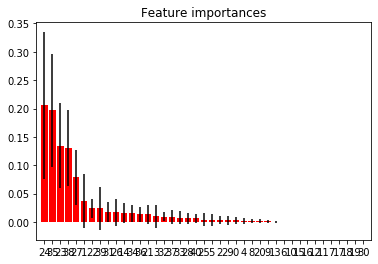

In [82]:

importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [83]:
final.columns[[24,35,23,38,27,1,22,39,31,26,14,34,36,21,3,32,37,33,28,40,25]]

Index(['nationality_ver2_North America', 'followers_ver2',
       'nationality_ver2_Europe', 'goals_ver2', 'age', 'join_date_ver2',
       'nationality_ver2_Asia', 'Assists_ver2', 'appearance_ver2',
       'nationality_ver2_South America', 'position_Defender', 'following_ver2',
       'likes_ver2', 'nationality_ver2_Africa', 'sent_score', 'minutes_ver2',
       'date_joined_twitter_ver3', 'num_tweets_ver2', 'startelfquote',
       'min_per_goal_ver2', 'nationality_ver2_Oceania'],
      dtype='object')

In [84]:
##############regression results

In [85]:
rf_y_pred = regr.predict(X_test)


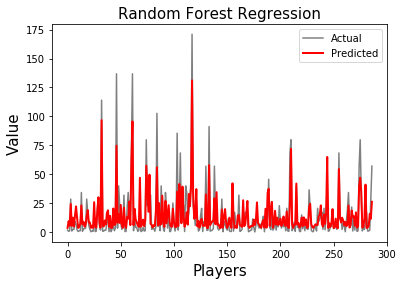

In [86]:
plt.plot(y_test,  color='gray', label="Actual")
plt.plot(rf_y_pred, color='red', linewidth=2,label="Predicted")
plt.xlabel('Players',fontsize = 15)
plt.ylabel('Value',fontsize = 15)
plt.legend()
plt.title('Random Forest Regression',fontsize = 15)
plt.savefig('randomforest_results.png')
plt.show()


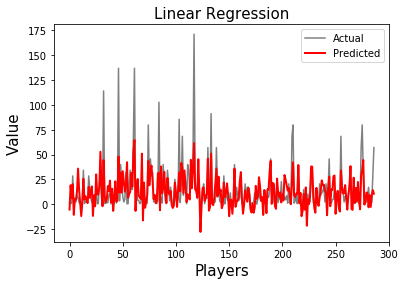

In [87]:
plt.plot(y_test,  color='gray', label="Actual")
plt.plot(lr_y_pred, color='red', linewidth=2,label="Predicted")
plt.xlabel('Players',fontsize = 15)
plt.ylabel('Value',fontsize = 15)
plt.legend()
plt.title('Linear Regression',fontsize = 15)
plt.savefig('Linear_results.png')
plt.show()

In [89]:
from sklearn.metrics import r2_score
lr_r2 = r2_score(y_test, lr_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

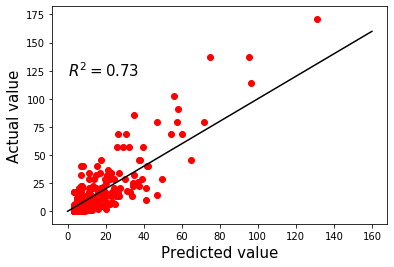

In [90]:
#####r2_score

plt.plot([0,160], [0,160], color = 'black')
plt.scatter(rf_y_pred, y_test, color='red')
plt.xlabel('Predicted value',fontsize = 15)
plt.ylabel('Actual value',fontsize = 15)

plt.text(0,120, r'$R^2 = {}$'.format("%.2f" % rf_r2), ha='left', rotation=0, wrap=True, fontsize = 15)

plt.savefig('randomforest.png')
plt.show()

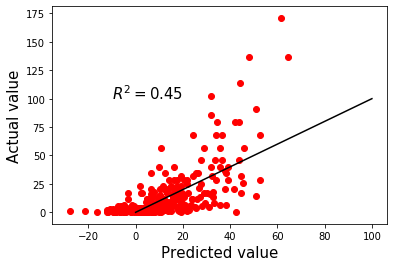

In [91]:
plt.plot([0,100], [0,100], color = 'black')
plt.scatter(lr_y_pred, y_test, color='red')
plt.xlabel('Predicted value',fontsize = 15)
plt.ylabel('Actual value',fontsize = 15)

plt.text(-10,100, r'$R^2 = {}$'.format("%.2f" % lr_r2), ha='left', rotation=0, wrap=True, fontsize = 15)

plt.savefig('linear.png')
plt.show()